In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from warnings import filterwarnings

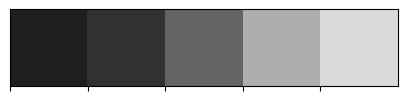

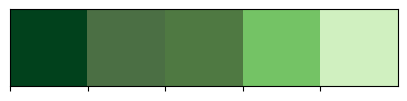

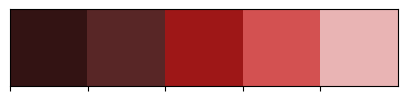

In [10]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [11]:
size = 150
batch = 32
dataset_training_path="/kaggle/input/brain-tumor-classification-mri/Training"
dataset_testing_path="/kaggle/input/brain-tumor-classification-mri/Testing"

# image_size: resizes the images
# batch_size: how many images at a time
# subset: allows me to return a tuple (train_data, val_data)
train_data = image_dataset_from_directory(directory=dataset_training_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

testing_data = image_dataset_from_directory(directory=dataset_testing_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

X_train = []
y_train = []

for images, labels in train_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for images, labels in testing_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy()) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print()
print(f"X_train.shape: {X_train.shape}")
print(f"y_train: {y_train.shape}")

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.

X_train.shape: (3264, 150, 150, 3)
y_train: (3264,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, 
                                                    test_size=0.125,
                                                    random_state=42)

In [13]:
y_test

array([0, 0, 0, 3, 1, 3, 1, 1, 3, 0, 0, 0, 3, 3, 2, 1, 1, 0, 3, 1, 3, 3,
       0, 1, 2, 3, 1, 2, 0, 2, 3, 1, 1, 3, 1, 3, 0, 2, 1, 1, 1, 2, 1, 2,
       3, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 3, 3, 0,
       1, 1, 3, 3, 0, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1,
       1, 0, 3, 3, 3, 0, 1, 2, 2, 0, 0, 1, 3, 2, 3, 1, 1, 0, 0, 1, 0, 0,
       3, 1, 3, 2, 1, 3, 1, 3, 1, 0, 1, 2, 0, 1, 3, 1, 1, 2, 0, 3, 3, 1,
       3, 1, 3, 3, 1, 0, 3, 1, 3, 2, 1, 3, 3, 3, 2, 3, 1, 2, 1, 3, 0, 0,
       3, 2, 3, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 0,
       3, 1, 3, 1, 1, 2, 0, 2, 1, 3, 1, 1, 3, 3, 1, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 0, 1, 3, 3, 1, 1, 1, 0, 1, 3, 0, 3, 1, 1, 3, 3, 3, 0, 3, 1,
       0, 1, 1, 2, 0, 3, 1, 2, 1, 0, 1, 2, 2, 3, 0, 3, 3, 3, 1, 1, 0, 1,
       1, 0, 0, 1, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 3,
       0, 1, 0, 0, 3, 3, 3, 3, 1, 2, 0, 1, 2, 1, 3, 1, 3, 1, 0, 1, 3, 0,
       2, 1, 1, 0, 3, 0, 1, 1, 1, 3, 2, 1, 3, 2, 2,

In [14]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [16]:
model = Sequential(
  [
      EfficientNetB0(weights='imagenet',
                        include_top=False,
                        input_shape=(size,size,3)),
      GlobalAveragePooling2D(),
      Dropout(rate=0.5),
      Dense(4, activation='linear')
  ]
)

model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer = Adam(learning_rate=0.001),
              metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 4054695 (15.47 MB)
Trainable params: 4012672 (15.31 MB)
Non-trainable params: 42023 (164.16 KB)
_____________

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')

checkpoint = ModelCheckpoint("effnet.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

In [18]:
history = model.fit(X_train,y_train,
                    validation_split=0.1, 
                    epochs=20, verbose=1, 
                    batch_size=32,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20


2023-11-27 02:04:26.919012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


81/81 [==============================] - ETA: 0s - loss: 0.4946 - accuracy: 0.8179
Epoch 1: val_accuracy improved from -inf to 0.86713, saving model to effnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 68s 179ms/step - loss: 0.4946 - accuracy: 0.8179 - val_loss: 0.4803 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9374
Epoch 2: val_accuracy improved from 0.86713 to 0.93007, saving model to effnet.h5
81/81 [==============================] - 11s 137ms/step - loss: 0.1833 - accuracy: 0.9374 - val_loss: 0.2086 - val_accuracy: 0.9301 - lr: 0.0010
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9556
Epoch 3: val_accuracy improved from 0.93007 to 0.93357, saving model to effnet.h5
81/81 [==============================] - 11s 138ms/step - loss: 0.1222 - accuracy: 0.9556 - val_loss: 0.2736 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9661
Epoch 4: val_accuracy improved from 0.93357 to 0.94056, saving model to effnet.h5
81/81 [==============================

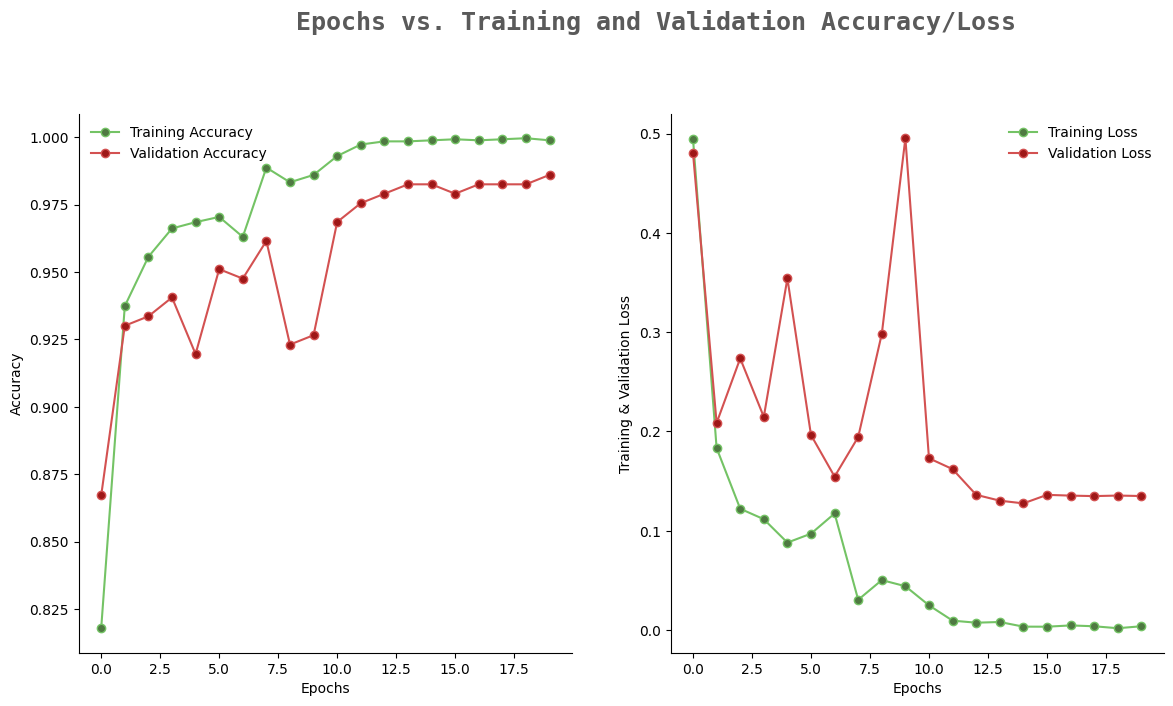

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',
         size=18,fontweight='bold',
        fontname='monospace',
         color=colors_dark[1],
         y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           markerfacecolor=colors_green[2],
           color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           markerfacecolor=colors_red[2],
           color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

13/13 [==============================] - 3s 89ms/step


In [21]:
print(classification_report(y_test_new,pred))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.96      0.96       134
           2       0.95      0.95      0.95        55
           3       0.96      0.99      0.98       110

    accuracy                           0.97       408
   macro avg       0.97      0.97      0.97       408
weighted avg       0.97      0.97      0.97       408



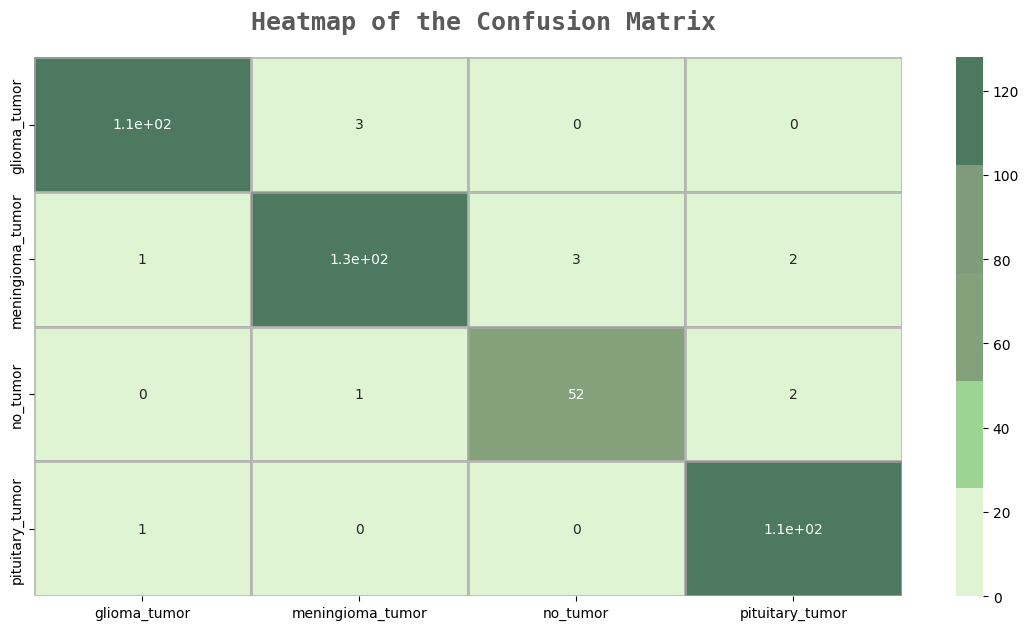

In [25]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor','pituitary_tumor']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,linewidths=2,
            linecolor=colors_dark[3])

fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()


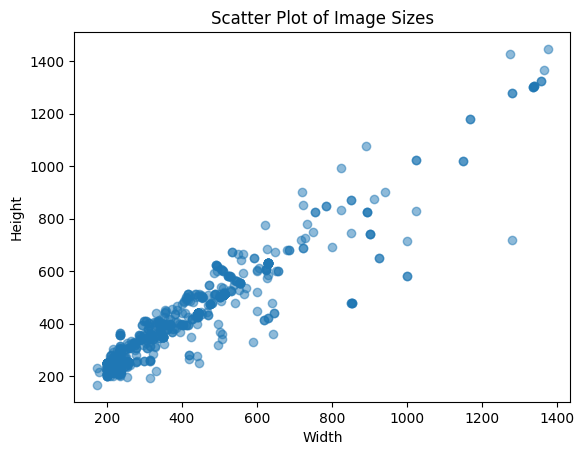

In [23]:
def get_image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        img = cv2.imread(path)
        height, width, _ = img.shape
        sizes.append((width, height))
    return sizes

image_directories = ["/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor"]
sizes = []
for di in image_directories:
    sizes.extend(get_image_sizes(di))

# Separate widths and heights for visualization
widths = [size[0] for size in sizes]
heights = [size[1] for size in sizes]

plt.scatter(widths, heights, alpha=0.5)
plt.title('Scatter Plot of Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score
def model_accuracy_and_confusion_matrix(model, Xtrain, ytrain, Xtest, ytest):
    ypred_train        = model.predict(Xtrain)
    ypred_train        = np.argmax(ypred_train, axis=1)
    ytrain             = np.argmax(ytrain, axis=1)
    accuracy_train     = accuracy_score(ytrain, ypred_train)
    conf_matrix_train  = confusion_matrix(ytrain, ypred_train)
    print(f'Accuracy for training data (R^2): {accuracy_train} \n')
    print('Confusion matrix for training data:\n', conf_matrix_train, '\n')

    ypred_test         = model.predict(Xtest)
    ypred_test         = np.argmax(ypred_test, axis=1)
    ytest              = np.argmax(ytest, axis=1)
    accuracy_train     = accuracy_score(ytest, ypred_test)
    conf_matrix_train  = confusion_matrix(ytest, ypred_test)
    print(f'Accuracy for testing data (R^2): {accuracy_train} \n')
    print('Confusion matrix for testing data:\n', conf_matrix_train, '\n')
    return None

In [40]:
model_accuracy_and_confusion_matrix(model, X_train, y_train, X_test, y_test)

90/90 [==============================] - 3s 32ms/step
Accuracy for training data (R^2): 0.9978991596638656 

Confusion matrix for training data:
 [[814   2   1   0]
 [  0 800   1   2]
 [  0   0 445   0]
 [  0   0   0 791]] 

13/13 [==============================] - 0s 31ms/step
Accuracy for testing data (R^2): 0.9681372549019608 

Confusion matrix for testing data:
 [[106   3   0   0]
 [  1 128   3   2]
 [  0   1  52   2]
 [  1   0   0 109]] 

